In [71]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ydata_profiling import ProfileReport
from textstat import flesch_reading_ease  # exploring text complixity
import nltk
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# classification
from transformers import BertTokenizer, BertModel
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
diplomacy= pd.read_json('../data/all_data.jsonl', lines=True)
diplomacy.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1


In [3]:
conversations = []
token = "|"
labels = []

for i, j in diplomacy.iterrows(): 
    if(len(j['messages']) == 0):
        print("Empty Row: " , i)
        continue
    conversations.append(token.join(j['messages']))
    labels.append(1)    
    
df1 = pd.DataFrame({'conversation': conversations, 'bad_intent': 1 })                     
df1.info()

Empty Row:  9
Empty Row:  62
Empty Row:  87
Empty Row:  96
Empty Row:  188
Empty Row:  249
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  246 non-null    object
 1   bad_intent    246 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [4]:
df1.loc[0]['conversation']

'Germany!\n\nJust the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. \n\nSo...do I suggest it?\n\nI’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.\n\nWhat is your appetite like for unusual and crazy?|You\'ve whet my appetite, Italy. What\'s the suggestion?|👍|It seems like there are a lot of ways that could go wrong...I don\'t see why France would see you approaching/taking Munich--while I do nothing about it--and not immediately feel skittish|Yeah, I can’t say I’ve tried it and it works, cause I’ve never tried it or seen it. But how I think it would work is (a) my Spring move looks like an attack on Austria, so it would not be surprising if you did not cover Munich. Then (b) you build two armies, which looks lik

In [5]:
good = pd.read_csv('../data/full_dialog.csv')
good.head(2)

,Unnamed: 0,Unit,Turn,B4,B2
0,0,Good morning. How are you doing today?,0,0,20180904-045349_715_live
1,1,Hi. I am doing good. How about you?,0,1,20180904-045349_715_live


In [6]:
conversations = []
labels = []
n =0

for i, j in good.iterrows(): 
    # This is a new conversation, append the prevoius conversation to the conversations list
    if j['Turn'] == 0 and n == 2 :
        conversations.append(token.join(conv))
        labels.append(0)
        n=0
    # its the sencond turn=0 of each conversation
    if j['Turn'] == 0 and n == 1 :
        n =2
    # if its start of a new conversation including the very first one
    if j['Turn'] == 0 and n == 0 :
        conv = []
        # becouse there are two messages with turn=0 in each convrsation
        n =1
        
    conv.append(j['Unit'])

    
df2 = pd.DataFrame({'conversation': conversations, 'bad_intent': labels})                     
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  1016 non-null   object
 1   bad_intent    1016 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.0+ KB


In [7]:
df2.loc[0]['conversation']

"Good morning. How are you doing today?|Hi. I am doing good. How about you?|I'm doing pretty good for a Tuesday morning. |Haha. Same here, but it really feels like a Monday.|Ugh yes it does!|I can not believe how warm it is already.|Where are you from? |I am from the Midwest. What about you?|I'm from the South East. It's always warm here. |Oh, yep. You are definitely in for warm weather, which is great as far as I am concerned.|We're about to get hit by a tropical storm.|I heard that some bad weather was going to be coming. I hope it is not too severe.|Me too. It's just part of living on the Gulf. You have to be prepared for it.|Yes, I am sure you get a lot of storms.|We do. I guess I should get into what this chat is supposed to be about. Have you heard of the Charity Save The Children?|I have heard about them. What do you like about them?|I like that they're committed to helping children in need. They're very transparent in their work and do great things to help children in underpriv

In [8]:
df = pd.concat([df1, df2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  1262 non-null   object
 1   bad_intent    1262 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.8+ KB


In [9]:
df

,conversation,bad_intent
0,Germany!\n\nJust the person I want to speak wi...,1
1,Hello there! What's your general plan for this...,1
2,Buongiorno! \nBe kinda nice to know if you're ...,1
3,Hey italy! good luck this game. I'm guessing y...,1
4,Hello Italy what’s up what are your thoughts o...,1
...,...,...
1257,"Good morning, how are you doing today?|I'm wel...",0
1258,hi|Hi how are you?|i'm fine how are you?|I'm f...,0
1259,"hi|Hello, how are you?|i am fine. how about yo...",0
1260,Hi there! How are you today?|I am fine how are...,0


---
### Preprocessing the combined dataset

In [10]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 
        # Remove numbers - not in this dataset!
        #text = re.sub(r'\d+', '', text)
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

In [12]:
df['conversation'] = text_preprocess(list(df['conversation']))
df

,conversation,bad_intent
0,Germany! Just the person I want to speak with...,1
1,Hello there! What's your general plan for this...,1
2,Buongiorno! Be kinda nice to know if you're l...,1
3,Hey italy! good luck this game. I'm guessing y...,1
4,Hello Italy what’s up what are your thoughts o...,1
...,...,...
1257,"Good morning, how are you doing today?|I'm wel...",0
1258,hi|Hi how are you?|i'm fine how are you?|I'm f...,0
1259,"hi|Hello, how are you?|i am fine. how about yo...",0
1260,Hi there! How are you today?|I am fine how are...,0


<Axes: >

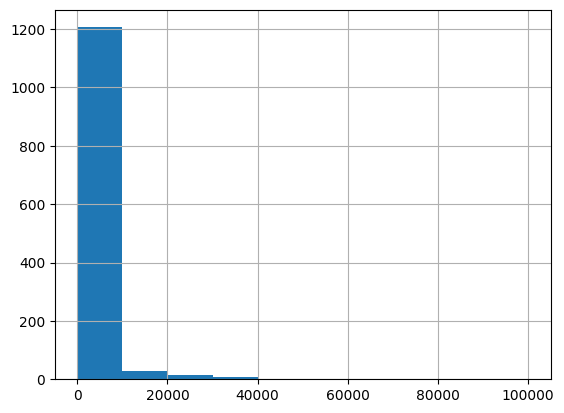

In [13]:
#number of characters in each conversation
df['conversation'].str.len().hist()

<Axes: >

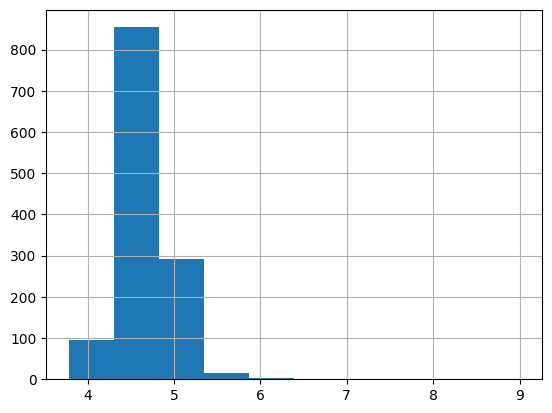

In [14]:
#  check the average word length
df['conversation'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()  

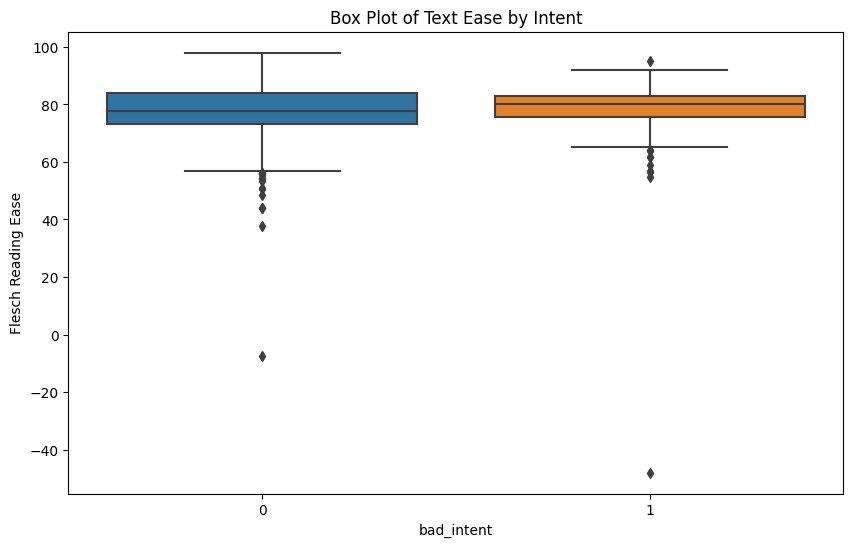

In [15]:
# flesch_reading_ease => 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (total_syllables / total_words)
text_ease = df['conversation'].apply(lambda x : flesch_reading_ease(x))
plt.figure(figsize=(10,6))
sns.boxplot(x=df['bad_intent'], y=text_ease)
plt.title('Box Plot of Text Ease by Intent')
plt.ylabel('Flesch Reading Ease')
plt.show()

In [16]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Noun (NN)
#Verb (VB)
#Adjective(JJ)
#Adverb(RB)
#Preposition (IN)
#Conjunction (CC)
#Pronoun(PRP)
#Interjection (INT)

# here i get all pos!
# the result of this function would be json which wont be really useful as a feature
def pos_tag_frequency(sentence):
    words = word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    #select the second element in each tuple
    tags = [tag for word, tag in pos_tags if tag == 'PRP']
    tag_freq = Counter(tags)
    return tag_freq

pron_freq = []
article_freq = []
prep_freq = []
adj_freq = []

for i, j in df.iterrows():       
    words = word_tokenize(j['conversation'])
    pos_tags = nltk.pos_tag(words)
    pron_freq.append(len([tag for word, tag in pos_tags if tag == 'PRP']))
    article_freq.append(sum([1 for word in words if word.lower() in ['the', 'a', 'an']]))
    prep_freq.append(len([tag for word, tag in pos_tags if tag == 'IN']))
    adj_freq.append(len([tag for word, tag in pos_tags if tag == 'JJ']))
    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


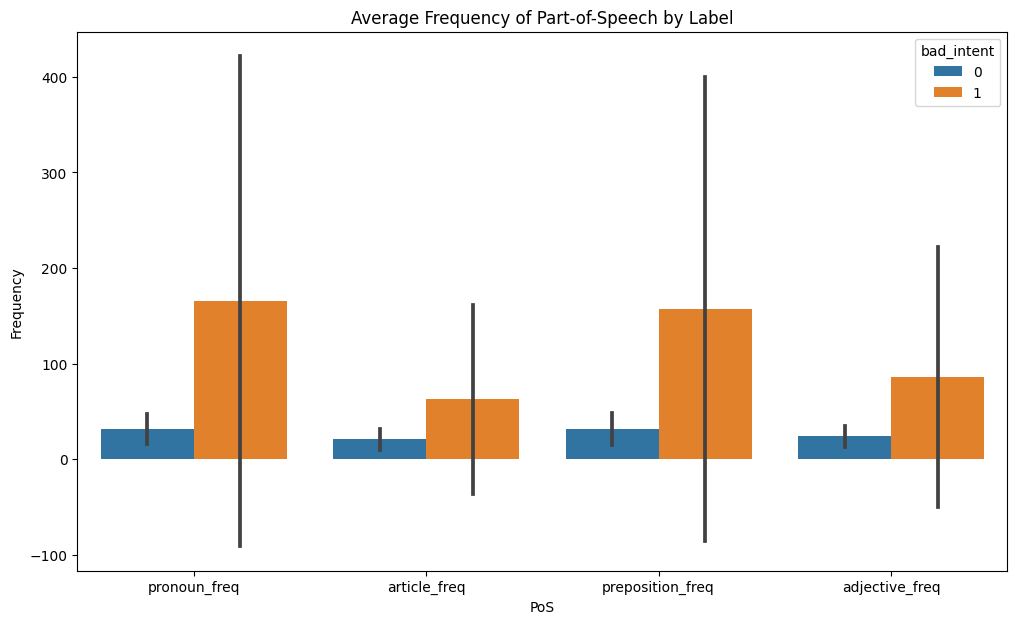

In [17]:
chart_df = pd.DataFrame()
chart_df['pronoun_freq'] = pron_freq
chart_df['article_freq'] = article_freq
chart_df['preposition_freq'] = prep_freq
chart_df['adjective_freq'] = adj_freq
chart_df['bad_intent'] = df['bad_intent']

df_melted = chart_df.melt(id_vars=['bad_intent'], value_vars=['pronoun_freq', 'article_freq', 'preposition_freq', 'adjective_freq'], 
                    var_name='PoS', value_name='Frequency')

plt.figure(figsize=(12, 7))
sns.barplot(x='PoS', y='Frequency', hue='bad_intent', data=df_melted, ci='sd')
plt.title('Average Frequency of Part-of-Speech by Label')
plt.show()

In [18]:
num_samples = len(df)
# Calculate the average number of words per sample
num_words = df['conversation'].apply(lambda x: len(x.split()))
avg_words_per_sample = num_words.mean()

# Calculate the ratio
ratio = num_samples / avg_words_per_sample
ratio

2.382143540898866

---
### Feature Extraction

In [82]:
# Later maybe try other word embeddings as well, so craete a dict to save them
embedings = {}
vocab_sizes = {}

In [21]:
def bert_family_embeddings(name, tokenizer, model):
    # tokenize all the texts and the convert tokens to ids
    tokenized_texts = tokenizer(list(df['conversation']), return_tensors='pt', padding='max_length', truncation=True, max_length = 128)
    # pass the tokenized texts through the  model
    with torch.no_grad():
        outputs = model(**tokenized_texts)
    # extract the embeddings (last layer's hidden states)
    model_embeddings = outputs.last_hidden_state
    vocab_size = tokenizer.vocab_size
    return model_embeddings , vocab_size

In [22]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
embedings['BERT'] , vocab_sizes['BERT'] = bert_family_embeddings('BERT', tokenizer, model)

In [23]:
print(" BERT Vocabulary Size:", vocab_sizes['BERT'])

 BERT Vocabulary Size: 30522


---
### Preaper dataset for classification

<Axes: xlabel='bad_intent', ylabel='count'>

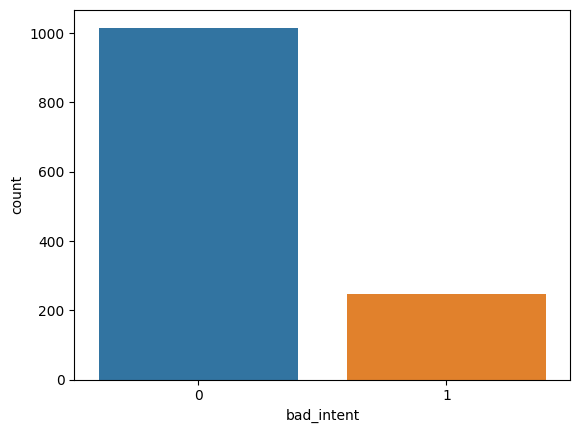

In [24]:
sns.countplot(data = df, x= df['bad_intent'])

#### balance the dataset or evalue the classification by weighted F1 score???

+ Normalization /scaling --> no need when using BERT
+ Shuffling --> shuffle=True in train_test_split


---
### Classification

In [72]:
models = {'LogisticRegression' :LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1) ,
          'LinearSVC' : LinearSVC(C = 2),
          'BernoulliNB' : BernoulliNB(alpha = 2)
         }                             

In [73]:
def evaluate_model(model, model_name, x_test, y_test):  
    # prediction
    y_pred = model.predict(x_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))    
    # Confusion matrix
    print(confusion_matrix(y_test, y_pred))
    return accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),f1_score(y_test, y_pred, average = 'weighted') 

In [78]:
accuracies  = {}
f1s = {}
precisions = {}
recalls = {}
# embeddings and df_features dictionaries have the same keys
for i in embedings:
    accuracies.update({i : {}})
    precisions.update({i: {}})
    recalls.update({i: {}})
    f1s.update({i: {} })
    # spilit the dataset to train and test sets:
    print(f'Embeddin: {i} ')
    X_train, X_test, y_train, y_test = train_test_split(embedings[i], df['bad_intent'], test_size = 0.3, random_state = 42, shuffle=True)    
    X_train = X_train.view(X_train.size(0), -1)
    X_test = X_test.view(X_test.size(0), -1)

    for name, model in models.items():
        print(f'Model: {name} ')
        model.fit(X_train, y_train)
        # Evaluate the model
        accuracy, precision, recall, f1 = evaluate_model(model, name,X_test , y_test)
        # metrics
        accuracies[i].update({name : accuracy})
        precisions[i].update({name: precision})
        recalls[i].update({name: recall})
        f1s[i].update({name: f1 })
        print()

Embeddin: BERT 
Model: LogisticRegression 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       310
           1       1.00      1.00      1.00        69

    accuracy                           1.00       379
   macro avg       1.00      1.00      1.00       379
weighted avg       1.00      1.00      1.00       379

[[310   0]
 [  0  69]]

Model: LinearSVC 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       310
           1       1.00      1.00      1.00        69

    accuracy                           1.00       379
   macro avg       1.00      1.00      1.00       379
weighted avg       1.00      1.00      1.00       379

[[310   0]
 [  0  69]]

Model: BernoulliNB 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       310
           1       0.99      1.00      0.99        69

    accuracy                           1.00       379

In [79]:
def model_eval_bar_plot(eval_dict, y_label):
    df_eval = pd.DataFrame(eval_dict)
    df_eval = df_eval.reset_index()
    # melt the DataFrame for plotting
    df_eval_melted = pd.melt(df_eval, id_vars='index', var_name='Embedding Model', value_name=y_label)
    # create a bar plot using Seaborn's barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_eval_melted, x='Embedding Model', y=y_label, hue='index')
    plt.title('Sentiment Analysis Evaluations Results')
    plt.xlabel('Embedding Model')
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend(title='Classification Model')
    plt.savefig("classification_results_bar.png", dpi=300, bbox_inches="tight")
    plt.show() 

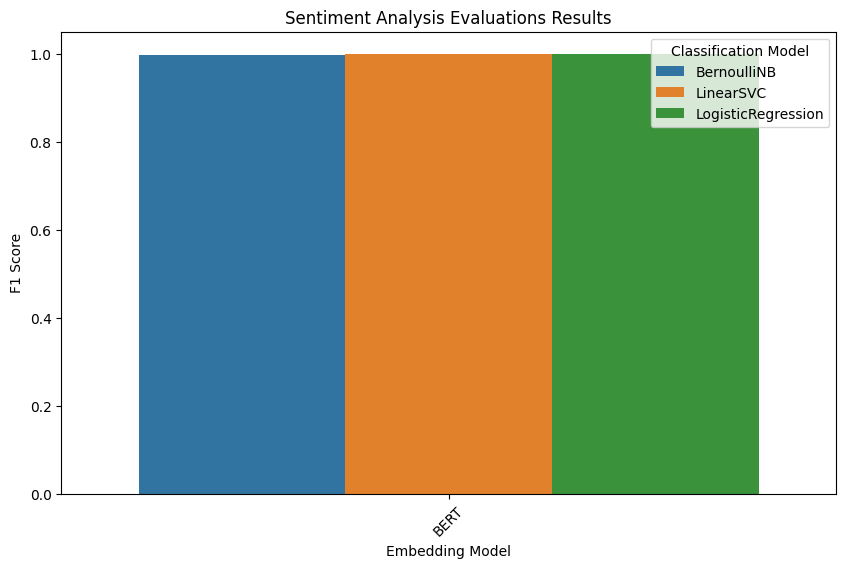

In [80]:
model_eval_bar_plot(f1s, 'F1 Score')

---
### CNN Classification

In [70]:
def plot_f1_scores(all_f1s_train, all_f1s_val):
    epochs = range(1, len(all_f1s_train[0]) + 1)  #same number of epochs for all folds
 
    # Plotting each fold
    for i, (f1_train, f1_val) in enumerate(zip(all_f1s_train, all_f1s_val)):
        plt.plot(epochs, f1_train, label=f'Fold {i+1} Train', linestyle='--', color=f'C{i}')
        plt.plot(epochs, f1_val, label=f'Fold {i+1} Validation', color=f'C{i}')
 
    plt.title('Training and Validation Weighted F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()


In [60]:
class F1History(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super(F1History, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
 
    def on_train_begin(self, logs={}):
        self.f1s_train = []
        self.f1s_val = []
 
    def on_epoch_end(self, epoch, logs={}):
        train_probs = self.model.predict(self.X_train)
        train_preds = np.argmax(train_probs, axis=1)
        self.f1s_train.append(f1_score(self.y_train, train_preds, average='weighted'))
 
        val_probs = self.model.predict(self.X_val)
        val_preds = np.argmax(val_probs, axis=1)
        self.f1s_val.append(f1_score(self.y_val, val_preds, average='weighted'))

In [63]:
def cnn_classify(name):
    model_embeddings = embedings[name].numpy()  # a typo in the original code: 'embedings' -> 'embeddings'
    X = model_embeddings
    y = df['bad_intent']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    embedding_dim = model_embeddings.shape[-1]
    num_classes = 2
    max_sequence_length = X_train.shape[1]
    num_folds = 3 
    cv_scores = []
    # Create StratifiedKFold instance for cross-validation
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    # lists to store F1 scores across all epochs for all folds
    all_f1s_train = []
    all_f1s_val = []
    # Iterate through each fold
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
 
        model = Sequential([
            Conv1D(128, 5, activation='relu', input_shape=(max_sequence_length, embedding_dim)),
            Conv1D(64, 3, activation='relu', padding='same'),
            GlobalMaxPooling1D(),
            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        # instance of F1History with training and validation data
        f1_history = F1History(X_train, y_train, X_val, y_val)
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[f1_history])
        
        # Evaluate the model on the validation data for this fold
        val_probs = model.predict(X_val)
        val_preds = np.argmax(val_probs, axis=1)
        weighted_f1 = f1_score(y_val, val_preds, average = 'weighted')
        cv_scores.append(weighted_f1)
 
        # store F1 scores of this fold
        all_f1s_train.append(f1_history.f1s_train)
        all_f1s_val.append(f1_history.f1s_val)
 
    avg_cv_f1 = np.mean(cv_scores)
    print(f'Average Cross-Validation Weighted F1 Score: {avg_cv_f1:.4f}')
    return all_f1s_train, all_f1s_val

In [64]:
all_f1s_train, all_f1s_val = cnn_classify('BERT')

Epoch 1/10
27/27 [==============================] - 4s 116ms/step - loss: 1.7916 - accuracy: 0.8644 - val_loss: 1.3214 - val_accuracy: 0.9952
Epoch 2/10
27/27 [==============================] - 3s 94ms/step - loss: 1.1847 - accuracy: 0.9929 - val_loss: 1.0033 - val_accuracy: 1.0000
Epoch 3/10
27/27 [==============================] - 3s 94ms/step - loss: 0.9035 - accuracy: 0.9929 - val_loss: 0.7727 - val_accuracy: 1.0000
Epoch 4/10
27/27 [==============================] - 3s 94ms/step - loss: 0.6915 - accuracy: 1.0000 - val_loss: 0.6020 - val_accuracy: 1.0000
Epoch 5/10
27/27 [==============================] - 3s 98ms/step - loss: 0.5445 - accuracy: 0.9976 - val_loss: 0.4763 - val_accuracy: 0.9976
Epoch 6/10
27/27 [==============================] - 3s 95ms/step - loss: 0.4260 - accuracy: 1.0000 - val_loss: 0.3748 - val_accuracy: 1.0000
Epoch 7/10
27/27 [==============================] - 3s 96ms/step - loss: 0.3407 - accuracy: 0.9988 - val_loss: 0.3005 - val_accuracy: 1.0000
Epoch 8/10
2

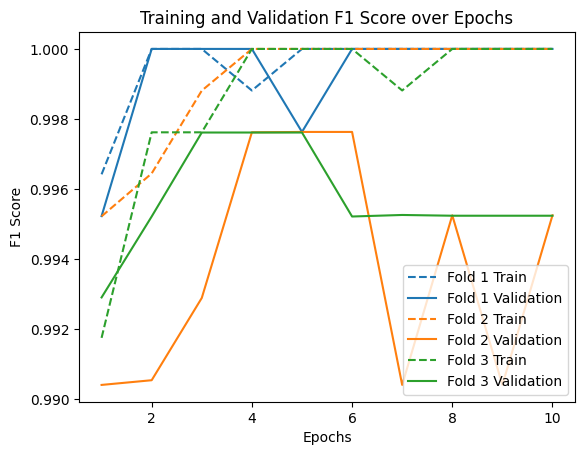

In [68]:
plot_f1_scores(all_f1s_train, all_f1s_val)

---
### LSTM